# Librairies

In [1]:
import glob
from pathlib import Path
import os
import sys
from datetime import date

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import geopandas as gpd

from PIL import Image, ImageMath

import math

import warnings
import logging

from keras.layers import Input, Dense, Conv1D, Conv2D, concatenate, Flatten, MaxPooling2D, Dropout
from keras.models import Model, Sequential, load_model
from keras.optimizers import Adam, RMSprop, SGD
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.regularizers import l1 
    
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import MinMaxScaler

from pytictoc import TicToc

from numpy.random import seed
seed(1)



/home/charles/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
rootDir = '/home/charles/Projects/NeuralNetPopulation'
provider = 'Mapbox'
gridSize = 100
resp="v_CA16_406"
finalNonLin = 'linear'
optimizerClass = Adam
lrInit=10**-2

In [3]:
sys.path.append("/home/charles/Projects/NeuralNetPopulation/Python") #watch out, PosixPath do not work

from dataGeneration.dataGeneratorFactory import DataGeneratorFactory
from dataGeneration.rawDataInput import RawDataInput

from models.convNetParams import ConvNetParams
from models.mdlFit import MdlFit
from utils.pathBuilder import PathBuilder

# Load the model, and dataloader objects

In [4]:
myPathBuilder = PathBuilder(rootDir,
                                provider,
                                gridSize)

myRawDataInput = RawDataInput(myPathBuilder,
                                  idGrid='gridId',
                                  provider=provider,
                                  gridSize=gridSize,
                                  resp=resp,
                                  ubNumTotal=np.inf)  # consider all the data

myConvNetParams = ConvNetParams(provider=provider,
                                    gridSize=gridSize,
                                    resp=myRawDataInput.resp,
                                    dim=myRawDataInput.dim,
                                    numImgs=myRawDataInput.numImgs,
                                    finalNonLin=finalNonLin,
                                    lr=lrInit,
                                    numEpochs=20,
                                    batchSize=2 ** 5,
                                    l1Coeff=0,
                                    dropoutRate=0.1,
                                    convNetClass=VGG19,
                                    scalerClass=MinMaxScaler,
                                    shuffle=False,
                                    verbose=True)

myDatageneratorFactory = DataGeneratorFactory(myRawDataInput,
                                                  myConvNetParams,
                                                  myPathBuilder)

dictTrainTestValid=myDatageneratorFactory.getTrainTestValidDataGenerators()

myMdlFit = MdlFit(myDatageneratorFactory,
                      myConvNetParams,
                      myPathBuilder)

myMdlFit.convNetMdlCustom

Directory /home/charles/Projects/NeuralNetPopulation/Data/Models/Partition/Mapbox/100 already exists
Directory /home/charles/Projects/NeuralNetPopulation/Figures/Mapbox/100 already exists
Directory /home/charles/Projects/NeuralNetPopulation/Data/Models/Mapbox/100 already exists
Directory /home/charles/Projects/NeuralNetPopulation/ModelHistory/Mapbox/100 already exists
Directory /home/charles/Projects/NeuralNetPopulation/Log/mdlFittingLogs/Mapbox/100 already exists
Directory /home/charles/Projects/NeuralNetPopulation/Data/Models/Checkpoint/Mapbox/100 already exists
All train, test, valid indices already exist for {self.convNetParams.mdlId}
Using a scale factor of 255.0 in DataGenerator
Using a scale factor of 255.0 in DataGenerator
Using a scale factor of 255.0 in DataGenerator
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 480, 480, 3)]     0         

In [7]:
numImgBatches=1

## Get the train and test sets

In [8]:
trainGenerator = dictTrainTestValid['train']
testGenerator = dictTrainTestValid['test']

In [9]:
listTupleXyTrain = [ (X,y) for k,(X,y) in enumerate(trainGenerator) if k <= numImgBatches ]
listTupleXyTest = [ (X,y) for k,(X,y) in enumerate(testGenerator) if k <= numImgBatches ]

In [10]:
X,y=trainGenerator[0]
X.shape, y.shape, listTupleXyTrain[0][0].shape, listTupleXyTrain[0][1].shape

((32, 480, 480, 3), (32, 1), (32, 480, 480, 3), (32, 1))

In [11]:
yTrain = np.concatenate( [tup[1] for tup in listTupleXyTrain ])
yTest = np.concatenate(  [tup[1] for tup  in listTupleXyTest ])

yTrain=yTrain[:2]
yTest= yTest[:2]

XTrain = np.concatenate( [tup[0]  for tup in listTupleXyTrain ] )
XTest = np.concatenate([tup[0]  for tup in listTupleXyTest] )

XTrain =XTrain [:2,:,:,:]
XTest =XTest [:2,:,:,:]

yTrain.shape, yTest.shape, XTrain.shape, XTest.shape

((2, 1), (2, 1), (2, 480, 480, 3), (2, 480, 480, 3))

# Get the output after the first 4 conv blocks (conv filters+ pooling)

In [30]:
vggSubModel=myMdlFit.convNetMdlCustom.get_layer('model_2')
inputLyr = vggSubModel.layers[0]
listBlockNames=[f'block{k+1}_pool' for k in range(4)]
listBlock=[vggSubModel.get_layer(listBlockNames[k]) for k in range(4)]
listSubModels=[ Model(inputLyr.input, listBlock[k].output) for k in range(4)]
listFeatmaps=[ subModel.predict( XTrain)  for subModel in  listSubModels ]

# Plot

In [64]:
def plotFeatMapSubModel(submdl,layer,imgTrainIdx, maxCells=64,maxRows=8):
    
    fig=plt.figure(figsize=(10,10))
    
    
    featMap = submdl.predict( XTrain) 
    
    numFeatMaps=min(maxCells, featMap.shape[3])
    numRows=min(maxRows, int(np.floor(np.sqrt(numFeatMaps))))
    
    for i in range(numFeatMaps):
        plt.subplot(numRows,numRows,i+1)
        plt.imshow(featMap[imgTrainIdx,:,:,i])
        
    plt.suptitle(f"Feature map for layer{layer}")
    
    pathFeatMapImg= myPathBuilder.figuresOutputPath / 'FeatureMaps' / f'image_{imgTrainIdx}_layer_{layer}.png'
    fig.savefig( pathFeatMapImg)

In [71]:
def plotFeatMapSubModelOneImg(   imgTrainIdx=0,  maxCells=64):

    maxRows=int(np.floor(np.sqrt(maxCells)))
    
    #Now plt each of the feature maps
    fig=plt.figure(figsize=(5,5))
    
    #Plot the raw oiriginal image
    plt.imshow(XTrain[imgTrainIdx])
    plt.suptitle(f'Original image {imgTrainIdx}')
    
    pathFeatMapImg= myPathBuilder.figuresOutputPath / 'FeatureMaps' / f'image_{imgTrainIdx}_original.png'
    fig.savefig( pathFeatMapImg)

    for  k in range(4):
        plotFeatMapSubModel( listSubModels[k], k, imgTrainIdx, maxCells, maxRows)
        

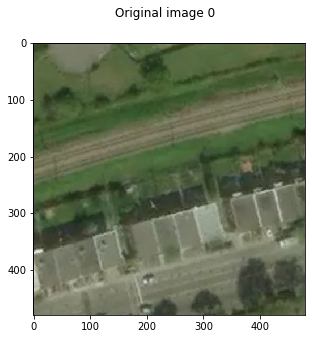

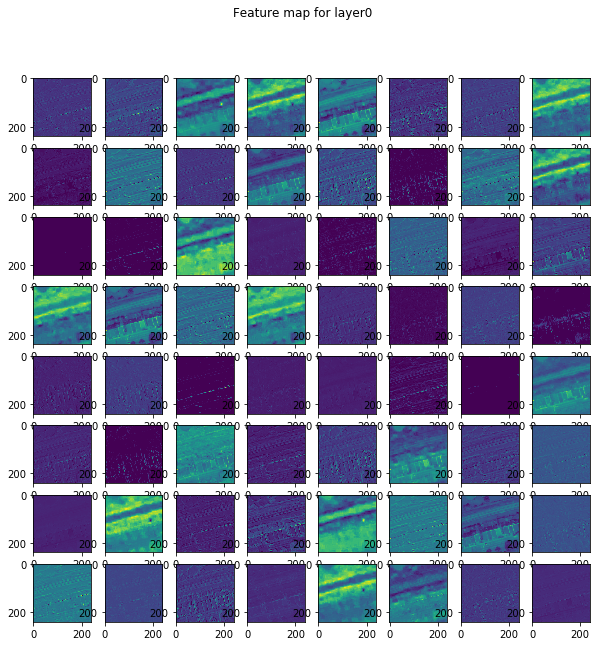

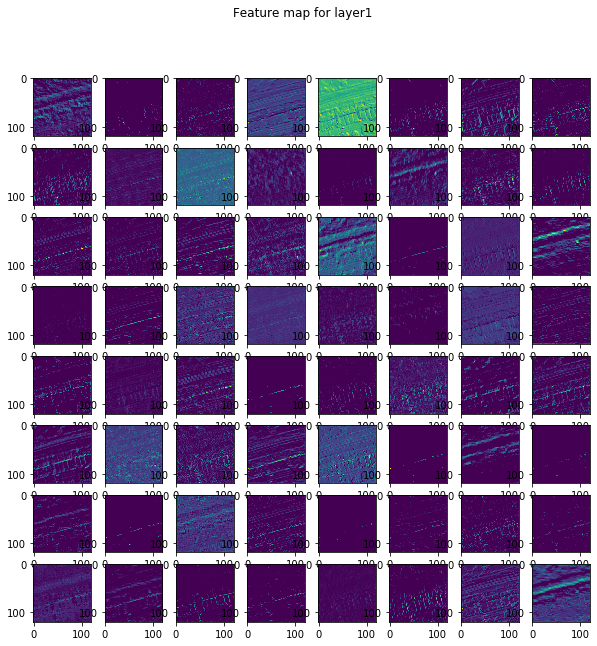

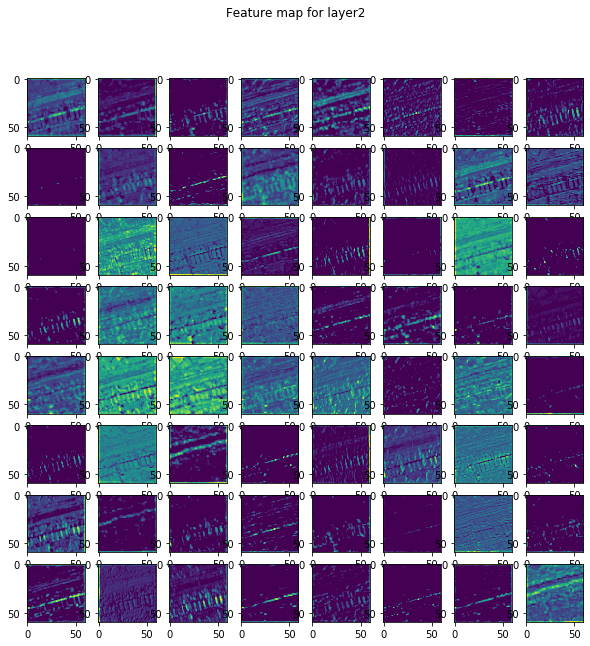

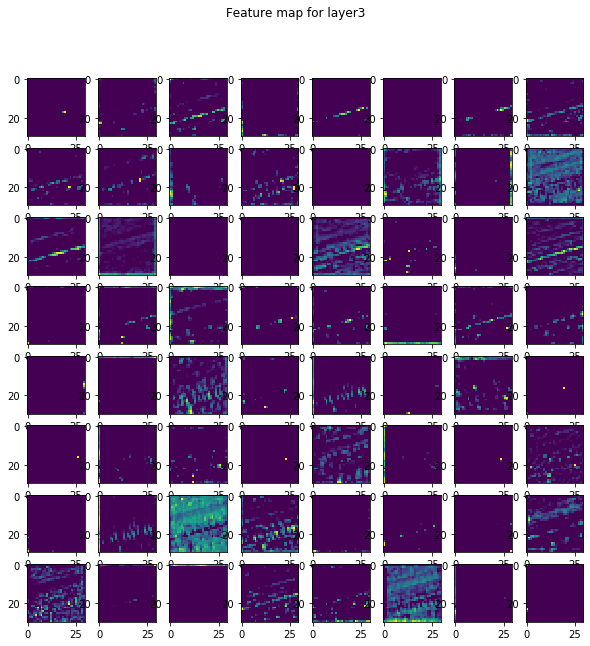

In [72]:
plotFeatMapSubModelOneImg(0)

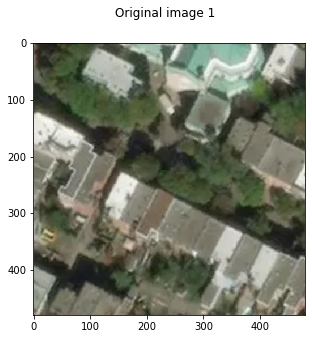

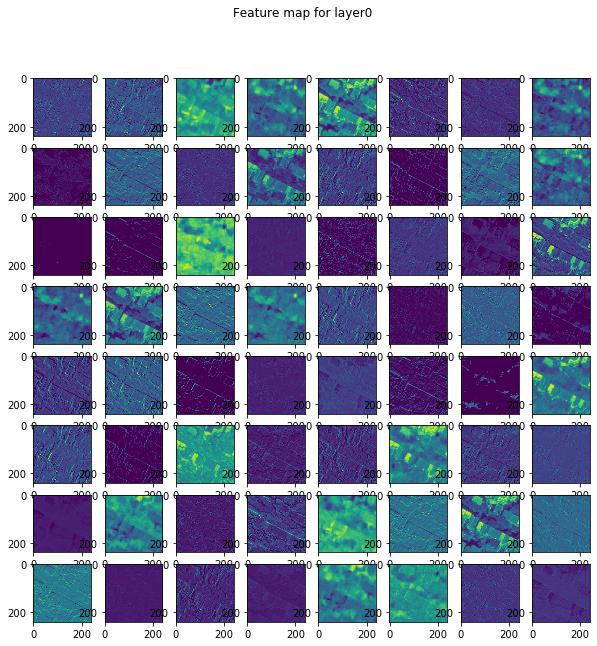

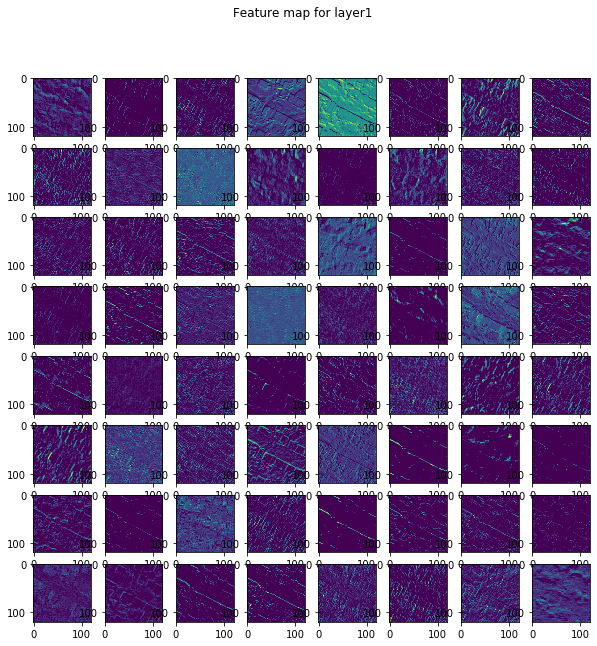

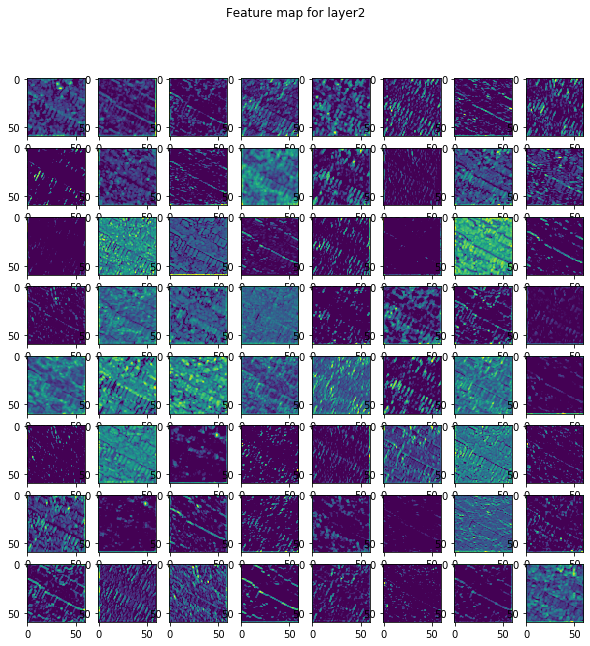

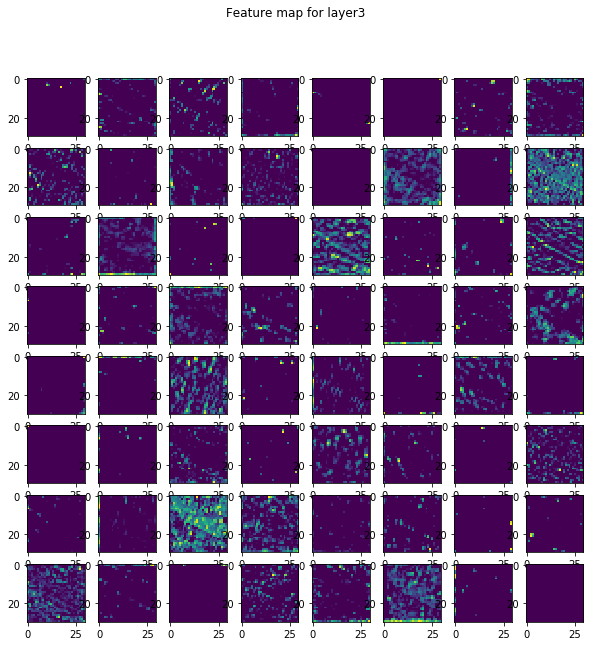

In [73]:
plotFeatMapSubModelOneImg(1)